In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [4]:
args = {
    "dataset": r"D:\deep learning\garbage detection", 
    "plot": "plot.png",
    "model": "mask_detectorch.model"
}

In [5]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [6]:
print("[INFO] loading images from the dataset...")
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

[INFO] loading images from the dataset...


In [7]:
for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	data.append(image)
	labels.append(label)

In [8]:
data= np.array(data, dtype="float32")
labels = np.array(labels)


In [20]:
import collections
count1=collections.Counter(labels)
print(count1)
data1=[]
label1=[]
for i in range(len(labels)):
    if count1[labels[i]]!='garbage detection':
        data1.append(data[i])
        label1.append(labels[i])
data = np.array(data1, dtype="float32")
labels = np.array(label1)


Counter({3: 594, 1: 501, 4: 482, 2: 410, 0: 403, 5: 137})


In [21]:
lb =LabelEncoder()
labels = lb.fit_transform(labels)

In [22]:
print(collections.Counter(labels))

Counter({3: 594, 1: 501, 4: 482, 2: 410, 0: 403, 5: 137})


In [23]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, random_state=42)

In [24]:
from tensorflow.keras.utils import to_categorical

trainY = to_categorical(trainY)
testY = to_categorical(testY)


In [25]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [26]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

In [33]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(6, activation="softmax")(headModel)

In [34]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [35]:
for layer in baseModel.layers:
	layer.trainable = False

In [36]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [39]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
63/63 [==============================] - 176s 3s/step - loss: 0.4649 - accuracy: 0.8281 - val_loss: 0.4703 - val_accuracy: 0.8419
Epoch 2/20
63/63 [==============================] - 174s 3s/step - loss: 0.4318 - accuracy: 0.8446 - val_loss: 0.4729 - val_accuracy: 0.8360
Epoch 3/20
63/63 [==============================] - 187s 3s/step - loss: 0.4417 - accuracy: 0.8446 - val_loss: 0.4668 - val_accuracy: 0.8458
Epoch 4/20
63/63 [==============================] - 170s 3s/step - loss: 0.4483 - accuracy: 0.8396 - val_loss: 0.4637 - val_accuracy: 0.8458
Epoch 5/20
63/63 [==============================] - 178s 3s/step - loss: 0.4445 - accuracy: 0.8436 - val_loss: 0.4588 - val_accuracy: 0.8498
Epoch 6/20
63/63 [==============================] - 166s 3s/step - loss: 0.4114 - accuracy: 0.8517 - val_loss: 0.4602 - val_accuracy: 0.8458
Epoch 7/20
63/63 [==============================] - 169s 3s/step - loss: 0.4098 - accuracy: 0.8477 - val_loss: 0.4571 - val_accura

In [40]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


[INFO] evaluating network...
16/16 [==============================] - 8s 504ms/step


In [41]:
print(np.unique(testY.argmax(axis=1)))
print(np.unique(predIdxs))
print(np.unique(trainY.argmax(axis=1)))
print(predIdxs.shape)


[0 1 2 3 4 5]
[1.6505897e-08 3.3846653e-08 3.4593953e-08 ... 9.9992168e-01 9.9993658e-01
 9.9993885e-01]
[0 1 2 3 4 5]
(506, 6)


In [44]:
target_names = ["Plastic", "Paper", "Trash", "Metal", "Glass",'Cardboard']  
predIdxs= np.argmax(predIdxs, axis=1)
print(classification_report(testY, predIdxs,
	target_names=target_names))


              precision    recall  f1-score   support

     Plastic       0.95      0.83      0.89        71
       Paper       0.85      0.82      0.83       107
       Trash       0.80      0.97      0.88        87
       Metal       0.88      0.90      0.89       118
       Glass       0.83      0.80      0.81        99
   Cardboard       0.60      0.50      0.55        24

    accuracy                           0.85       506
   macro avg       0.82      0.80      0.81       506
weighted avg       0.85      0.85      0.84       506



In [45]:
print("[INFO] saving mask detector model...")
model.save(args["model"], save_format="h5")

[INFO] saving mask detector model...


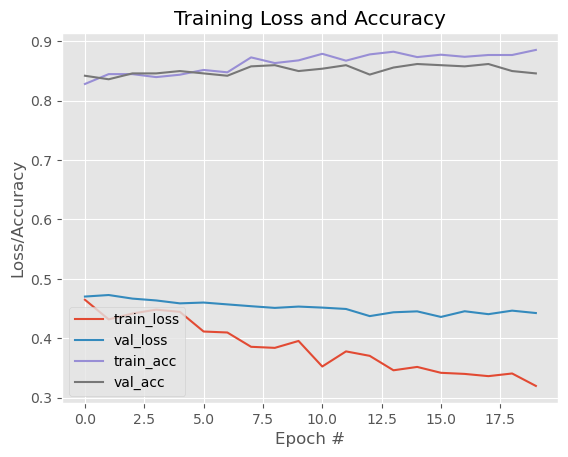

In [46]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])


In [47]:
model.save("garbage_classifier.h5")
